In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import cv2  

# 1. Introduction


This project aimed to develop and evaluate an advanced Convolutional Neural Network (CNN) architecture for image classification on the CIFAR-10 and CIFAR-100 datasets. The primary goal was to implement state-of-the-art techniques, including dropout, batch normalization, data augmentation, and residual connections—to build a robust model. The performance was benchmarked against existing literature, with a focus on achieving competitive accuracy and F1 scores.




## Data Preprocessing


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data augmentation and normalization
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load CIFAR-10 dataset
batch_size = 128
# Load CIFAR-10 training dataset and create a validation split
full_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
num_train = int(0.9 * len(full_trainset))
num_val = len(full_trainset) - num_train
train_subset, val_subset = random_split(full_trainset, [num_train, num_val])
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=4)

# Test loader remains the same.
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4)


100%|██████████| 170M/170M [00:13<00:00, 12.6MB/s]


# 2. Model Architecture

## Design Strategy:

In our study, we implemented a convolutional neural network (CNN) augmented with advanced features including residual connections, dropout, and batch normalization. We explored different architectural configurations by varying the activation functions (ReLU vs. Leaky ReLU) and kernel sizes (3×3 vs. 5×5) on the CIFAR‑10 dataset. These experiments were designed to understand how these variations impact feature extraction and overall model performance.  After evaluating each combination using accuracy, precision, recall, and F1 score metrics, we selected the best performing model based on the F1 score as the base for further experiments. This saved model was then used as the initialization point for training on the more challenging CIFAR‑100 dataset, leveraging transfer learning.


In [ ]:
#Add Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, activation='relu'):
        super(ResidualBlock, self).__init__()
        self.activation = activation
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        if self.activation == 'relu':
            act = F.relu
        elif self.activation == 'leaky_relu':
            act = F.leaky_relu

        out = act(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = act(out)
        return out


In [ ]:
#Set up CNN model
class CNNModel(nn.Module):
    def __init__(self, num_classes=10, activation='relu', kernel_size=3):
        super(CNNModel, self).__init__()
        self.activation = activation
        # First convolution: support different kernel sizes
        self.conv1 = nn.Conv2d(3, 64, kernel_size=kernel_size, stride=1, padding=kernel_size//2)
        self.bn1 = nn.BatchNorm2d(64)
        # Deepen the network by adding an extra residual block 
        self.resblock1 = ResidualBlock(64, 64, activation=activation)
        self.resblock2 = ResidualBlock(64, 128, stride=2, activation=activation)
        self.resblock3 = ResidualBlock(128, 256, stride=2, activation=activation)
        self.resblock4 = ResidualBlock(256, 512, stride=2, activation=activation)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        act = F.relu if self.activation == 'relu' else F.leaky_relu
        x = act(self.bn1(self.conv1(x)))
        x = self.resblock1(x)
        x = self.resblock2(x)
        x = self.resblock3(x)
        x = self.resblock4(x)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

## Train and Evaluation for CIFAR 10

### Training Strategy

Our training process involved a multi-phase approach to optimize both CIFAR‑10 and CIFAR‑100 performance. For CIFAR‑10, we conducted multiple experiments with:

*	Activation Functions: Both ReLU and Leaky ReLU were tested to assess their effect on learning, with Leaky ReLU mitigating the “dying ReLU” problem.
*	Kernel Sizes: We compared standard 3×3 kernels against larger 5×5 kernels to observe their impact on feature extraction.
*	Early Stopping & Learning Rate Scheduling: The training loop incorporated early stopping to prevent overfitting and used schedulers such as ReduceLROnPlateau for some experiments.

Once the best CIFAR‑10 model was selected, we transferred its weights (excluding the final fully connected layer) to initialize the CIFAR‑100 model. For CIFAR‑100, we further experimented with hyperparameter tuning using different optimizers and learning rate schedules. Specifically, we adopted SGD with momentum and a StepLR scheduler, which decayed the learning rate by a factor of 0.1 every 10 epochs.

Additionally, we explored a frozen schedule strategy where the backbone was frozen (only the final layer was trained) during an initial phase, followed by full-network fine-tuning. This multi-stage training was designed to balance the preservation of pre-learned features with the need to adapt to the increased class complexity of CIFAR‑100.

In [ ]:
def validate_model(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
         for images, labels in val_loader:
             images, labels = images.to(device), labels.to(device)
             outputs = model(images)
             loss = criterion(outputs, labels)
             running_loss += loss.item() * images.size(0)
             _, predicted = torch.max(outputs, 1)
             total += labels.size(0)
             correct += (predicted == labels).sum().item()
    avg_loss = running_loss / len(val_loader.dataset)
    accuracy = 100 * correct / total
    return avg_loss, accuracy


# Training function with early stopping

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler,
                num_epochs=20, save_path="model.pth", early_stop_patience=5):
    best_val_loss = float('inf')
    best_val_acc = 0.0
    early_stop_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = 100 * correct / total

        # Validate model on validation set
        val_loss, val_acc = validate_model(model, val_loader, criterion)
        scheduler.step(val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_acc = val_acc
            torch.save(model.state_dict(), save_path)
            print(f"--> Best model saved with Val Loss: {best_val_loss:.4f} and Val Acc: {best_val_acc:.2f}%")
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            print(f"Early stop counter: {early_stop_counter}/{early_stop_patience}")
            if early_stop_counter >= early_stop_patience:
                print("Early stopping triggered.")
                break

    print("Training complete.")

In [ ]:
# Evaluation Function
def evaluate_model(model, test_loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    print("Test Set Evaluation - CIFAR-10:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix - CIFAR-10")
    plt.show()

#### Experiment with different optimizer and kernel size

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/20] | Train Loss: 1.5640, Train Acc: 42.04% | Val Loss: 1.4613, Val Acc: 45.98%
--> Best model saved with Val Loss: 1.4613 and Val Acc: 45.98%
Epoch [2/20] | Train Loss: 1.0983, Train Acc: 60.74% | Val Loss: 1.0122, Val Acc: 63.84%
--> Best model saved with Val Loss: 1.0122 and Val Acc: 63.84%
Epoch [3/20] | Train Loss: 0.9006, Train Acc: 68.00% | Val Loss: 0.9341, Val Acc: 67.80%
--> Best model saved with Val Loss: 0.9341 and Val Acc: 67.80%
Epoch [4/20] | Train Loss: 0.7553, Train Acc: 73.63% | Val Loss: 0.7623, Val Acc: 74.40%
--> Best model saved with Val Loss: 0.7623 and Val Acc: 74.40%
Epoch [5/20] | Train Loss: 0.6599, Train Acc: 77.12% | Val Loss: 0.6735, Val Acc: 76.88%
--> Best model saved with Val Loss: 0.6735 and Val Acc: 76.88%
Epoch [6/20] | Train Loss: 0.5927, Train Acc: 79.35% | Val Loss: 0.6216, Val Acc: 78.88%
--> Best model saved with Val Loss: 0.6216 and Val Acc: 78.88%
Epoch [7/20] | Train Loss: 0.5451, Train Acc: 81.26% | Val Loss: 0.6070, Val Acc: 79.52%

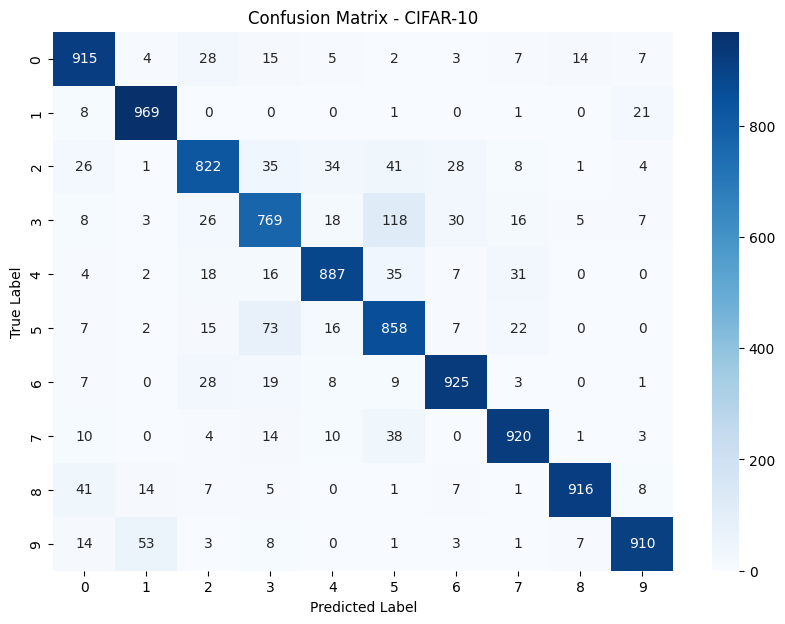

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/20] | Train Loss: 1.5553, Train Acc: 42.66% | Val Loss: 1.3365, Val Acc: 51.88%
--> Best model saved with Val Loss: 1.3365 and Val Acc: 51.88%
Epoch [2/20] | Train Loss: 1.0911, Train Acc: 61.05% | Val Loss: 0.9759, Val Acc: 65.20%
--> Best model saved with Val Loss: 0.9759 and Val Acc: 65.20%
Epoch [3/20] | Train Loss: 0.8881, Train Acc: 68.83% | Val Loss: 0.7799, Val Acc: 72.50%
--> Best model saved with Val Loss: 0.7799 and Val Acc: 72.50%
Epoch [4/20] | Train Loss: 0.7627, Train Acc: 73.24% | Val Loss: 0.7971, Val Acc: 71.78%
Early stop counter: 1/5
Epoch [5/20] | Train Loss: 0.6738, Train Acc: 76.62% | Val Loss: 0.6916, Val Acc: 75.52%
--> Best model saved with Val Loss: 0.6916 and Val Acc: 75.52%
Epoch [6/20] | Train Loss: 0.6106, Train Acc: 79.14% | Val Loss: 0.6257, Val Acc: 78.36%
--> Best model saved with Val Loss: 0.6257 and Val Acc: 78.36%
Epoch [7/20] | Train Loss: 0.5508, Train Acc: 80.93% | Val Loss: 0.5801, Val Acc: 80.40%
--> Best model saved with Val Loss: 0.

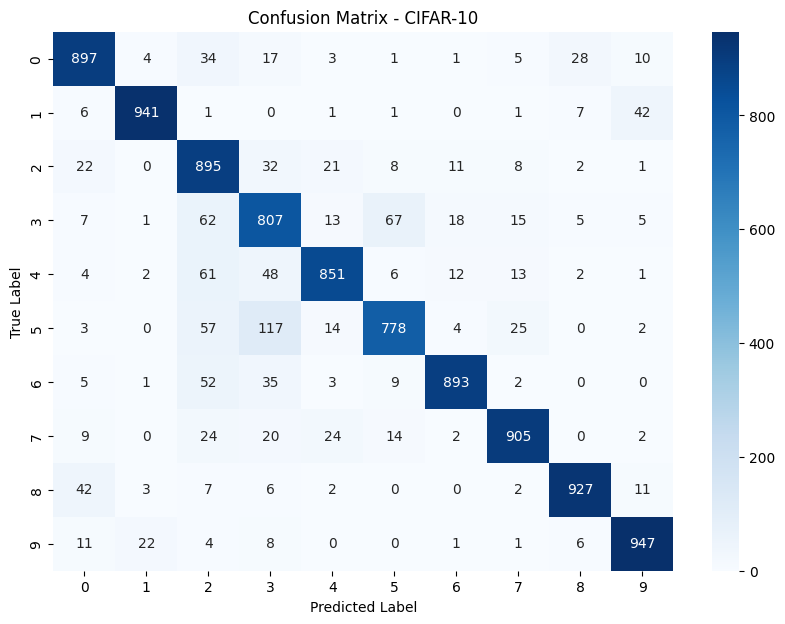

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/20] | Train Loss: 1.5166, Train Acc: 44.18% | Val Loss: 1.2977, Val Acc: 54.28%
--> Best model saved with Val Loss: 1.2977 and Val Acc: 54.28%
Epoch [2/20] | Train Loss: 1.0490, Train Acc: 62.66% | Val Loss: 1.1267, Val Acc: 59.90%
--> Best model saved with Val Loss: 1.1267 and Val Acc: 59.90%
Epoch [3/20] | Train Loss: 0.8624, Train Acc: 69.50% | Val Loss: 0.8339, Val Acc: 71.46%
--> Best model saved with Val Loss: 0.8339 and Val Acc: 71.46%
Epoch [4/20] | Train Loss: 0.7295, Train Acc: 74.72% | Val Loss: 0.6860, Val Acc: 76.62%
--> Best model saved with Val Loss: 0.6860 and Val Acc: 76.62%
Epoch [5/20] | Train Loss: 0.6388, Train Acc: 78.10% | Val Loss: 0.6283, Val Acc: 78.10%
--> Best model saved with Val Loss: 0.6283 and Val Acc: 78.10%
Epoch [6/20] | Train Loss: 0.5756, Train Acc: 80.12% | Val Loss: 0.6111, Val Acc: 78.90%
--> Best model saved with Val Loss: 0.6111 and Val Acc: 78.90%
Epoch [7/20] | Train Loss: 0.5250, Train Acc: 81.90% | Val Loss: 0.6025, Val Acc: 79.46%

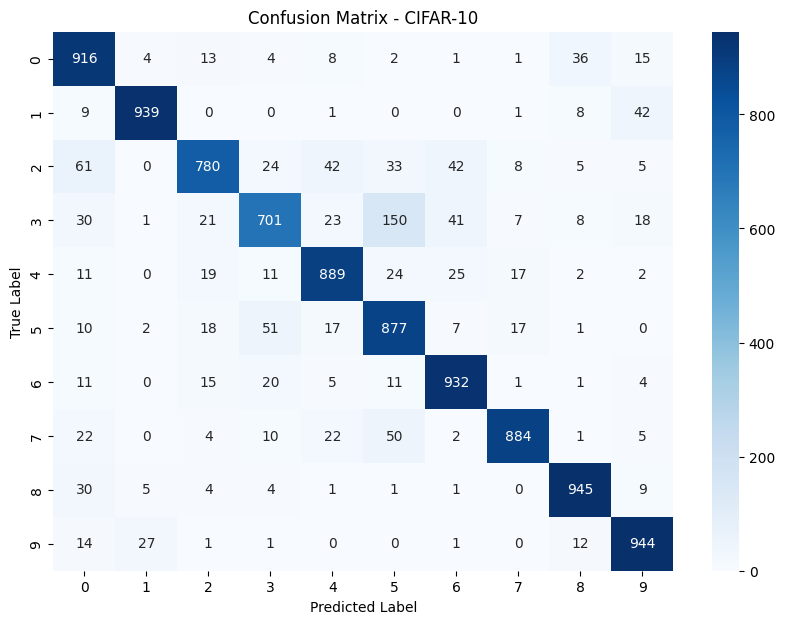

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/20] | Train Loss: 1.5114, Train Acc: 44.64% | Val Loss: 1.3385, Val Acc: 53.44%
--> Best model saved with Val Loss: 1.3385 and Val Acc: 53.44%
Epoch [2/20] | Train Loss: 1.0851, Train Acc: 61.39% | Val Loss: 1.1262, Val Acc: 59.78%
--> Best model saved with Val Loss: 1.1262 and Val Acc: 59.78%
Epoch [3/20] | Train Loss: 0.8863, Train Acc: 68.75% | Val Loss: 0.8509, Val Acc: 69.84%
--> Best model saved with Val Loss: 0.8509 and Val Acc: 69.84%
Epoch [4/20] | Train Loss: 0.7530, Train Acc: 73.82% | Val Loss: 0.6551, Val Acc: 76.60%
--> Best model saved with Val Loss: 0.6551 and Val Acc: 76.60%
Epoch [5/20] | Train Loss: 0.6668, Train Acc: 76.81% | Val Loss: 0.6437, Val Acc: 77.14%
--> Best model saved with Val Loss: 0.6437 and Val Acc: 77.14%
Epoch [6/20] | Train Loss: 0.6023, Train Acc: 79.14% | Val Loss: 0.6793, Val Acc: 76.18%
Early stop counter: 1/5
Epoch [7/20] | Train Loss: 0.5539, Train Acc: 80.72% | Val Loss: 0.6298, Val Acc: 78.64%
--> Best model saved with Val Loss: 0.

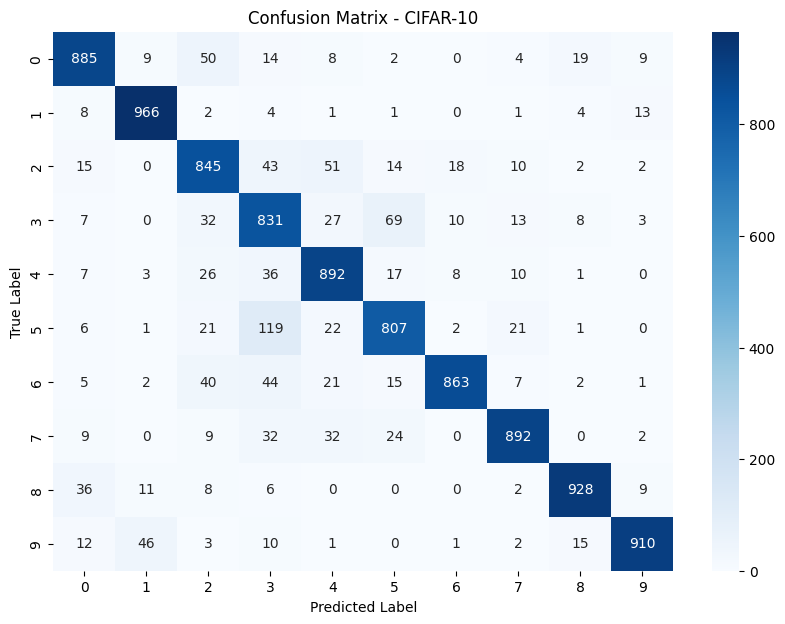

In [ ]:
#Experiment 1
model_leaky_3x3 = CNNModel(num_classes=10, activation='leaky_relu', kernel_size=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_leaky_3x3.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)

train_model(model_leaky_3x3, train_loader, val_loader, criterion, optimizer, scheduler,
            num_epochs=20, save_path="leaky_3x3.pth", early_stop_patience=5)

# Evaluate the best saved model
model_leaky_3x3.load_state_dict(torch.load("leaky_3x3.pth"))
evaluate_model(model_leaky_3x3, test_loader)

#Experiment 2
model_leaky_5x5 = CNNModel(num_classes=10, activation='leaky_relu', kernel_size=5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_leaky_5x5.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)

train_model(model_leaky_5x5, train_loader, val_loader, criterion, optimizer, scheduler,
            num_epochs=20, save_path="leaky_5x5.pth", early_stop_patience=5)

# Evaluate the best saved model
model_leaky_5x5.load_state_dict(torch.load("leaky_5x5.pth"))
evaluate_model(model_leaky_5x5, test_loader)



# Example: Experiment 3
model_relu_3x3 = CNNModel(num_classes=10, activation='relu', kernel_size=3).to(device)
optimizer = optim.Adam(model_relu_3x3.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)

train_model(model_relu_3x3, train_loader, val_loader, criterion, optimizer, scheduler,
            num_epochs=20, save_path="relu_3x3.pth", early_stop_patience=5)

# Evaluate the best saved model
model_relu_3x3.load_state_dict(torch.load("relu_3x3.pth"))
evaluate_model(model_relu_3x3, test_loader)

# Experiment 4
model_relu_5x5 = CNNModel(num_classes=10, activation='relu', kernel_size=5).to(device)
optimizer = optim.Adam(model_relu_5x5.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)

train_model(model_relu_5x5, train_loader, val_loader, criterion, optimizer, scheduler,
            num_epochs=20, save_path="relu_5x5.pth", early_stop_patience=5)

# Evaluate the best saved model
model_relu_5x5.load_state_dict(torch.load("relu_5x5.pth"))
evaluate_model(model_relu_5x5, test_loader)







##### Insights from Training on CIFAR-10

The experimental results indicate that, among the four variants evaluated on CIFAR‑10, the best-performing model based on the F1 score is the one using Leaky ReLU activation with a standard 3×3 kernel (F1 score: 0.8892).

This model not only achieved the highest balance between precision and recall but also demonstrated superior overall accuracy (approximately 88.91%).

In comparison, models employing a larger 5×5 kernel or using ReLU activation yielded slightly lower F1 scores (ranging from 0.8799 to 0.8856), suggesting that the standard 3×3 kernel combined with Leaky ReLU provides more effective feature extraction for this dataset.

The improved performance with Leaky ReLU may be attributed to its ability to mitigate issues such as the “dying ReLU” problem, thereby enabling the network to learn more robust representations.

These insights favor the selection of the Leaky ReLU 3×3 model as the optimal configuration, guiding further experimentation—especially if we plan to fine-tune or transfer this model to more complex datasets like CIFAR‑100.

## Train and Evaluation for CIFAR 100

In [ ]:
# Load CIFAR-100
full_trainset_cifar100 = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
num_train_cifar100 = int(0.9 * len(full_trainset_cifar100))
num_val_cifar100 = len(full_trainset_cifar100) - num_train_cifar100
train_subset_cifar100, val_subset_cifar100 = random_split(full_trainset_cifar100, [num_train_cifar100, num_val_cifar100])
train_loader_cifar100 = DataLoader(train_subset_cifar100, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader_cifar100 = DataLoader(val_subset_cifar100, batch_size=batch_size, shuffle=False, num_workers=4)

testset_cifar100 = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
test_loader_cifar100 = DataLoader(testset_cifar100, batch_size=batch_size, shuffle=False, num_workers=4)


100%|██████████| 169M/169M [00:13<00:00, 12.3MB/s]


In [ ]:
# Initialize a new model for CIFAR-100. Here we use the best CIFAR-10 model (relu_3x3) weights
model_cifar100 = CNNModel(num_classes=100, activation='relu', kernel_size=3).to(device)
pretrained_dict = torch.load("/content/relu_3x3.pth")
# Exclude the final FC layer weights (if present)
pretrained_dict = {k: v for k, v in pretrained_dict.items() if 'fc' not in k}
model_cifar100.load_state_dict(pretrained_dict, strict=False)
# Reinitialize the FC layer for 100 classes
model_cifar100.fc = nn.Linear(512, 100).to(device)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/50] | Train Loss: 2.8448, Train Acc: 27.39% | Val Loss: 2.2059, Val Acc: 41.18%
--> Best model saved with Val Loss: 2.2059 and Val Acc: 41.18%
Epoch [2/50] | Train Loss: 2.0696, Train Acc: 43.35% | Val Loss: 1.8890, Val Acc: 48.00%
--> Best model saved with Val Loss: 1.8890 and Val Acc: 48.00%
Epoch [3/50] | Train Loss: 1.8087, Train Acc: 49.62% | Val Loss: 1.7407, Val Acc: 51.82%
--> Best model saved with Val Loss: 1.7407 and Val Acc: 51.82%
Epoch [4/50] | Train Loss: 1.6627, Train Acc: 53.12% | Val Loss: 1.6632, Val Acc: 53.76%
--> Best model saved with Val Loss: 1.6632 and Val Acc: 53.76%
Epoch [5/50] | Train Loss: 1.5258, Train Acc: 56.86% | Val Loss: 1.5827, Val Acc: 55.94%
--> Best model saved with Val Loss: 1.5827 and Val Acc: 55.94%
Epoch [6/50] | Train Loss: 1.4206, Train Acc: 59.44% | Val Loss: 1.4808, Val Acc: 57.88%
--> Best model saved with Val Loss: 1.4808 and Val Acc: 57.88%
Epoch [7/50] | Train Loss: 1.3437, Train Acc: 61.38% | Val Loss: 1.5149, Val Acc: 58.18%

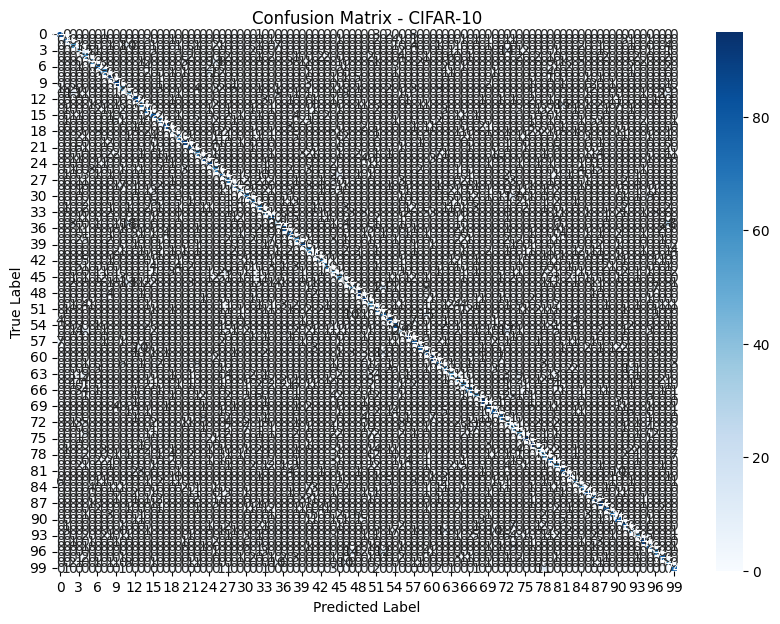

In [ ]:
optimizer = optim.Adam(model_cifar100.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)

train_model(model_cifar100, train_loader_cifar100, val_loader_cifar100, criterion, optimizer, scheduler,
            num_epochs=50, save_path="relu_3x3_cifar100.pth", early_stop_patience=5)

model_cifar100.load_state_dict(torch.load("relu_3x3_cifar100.pth"))
print("Evaluation on CIFAR-100:")
evaluate_model(model_cifar100, test_loader_cifar100)

##### Insight from initial training

The evaluation results reveal a noticeable performance gap between the CIFAR‑10 and CIFAR‑100 tasks. The best CIFAR‑10 model (which achieved an F1 score around 0.889) for CIFAR‑100 using its weights, but the resulting model attained an F1 score of approximately 0.689 with an accuracy of about 68.93%. This drop is expected given that CIFAR‑100 contains 100 classes, introducing much higher complexity and finer distinctions between classes than the 10 classes in CIFAR‑10.

## Model Fine tuning

### Different optimizer and Schedule

Epoch [1/30] | Train Loss: 3.1270, Train Acc: 21.71% | Val Loss: 2.7103, Val Acc: 30.30%
--> Best model saved with Val Loss: 2.7103 and Val Acc: 30.30%
Epoch [2/30] | Train Loss: 2.4683, Train Acc: 34.10% | Val Loss: 2.3250, Val Acc: 38.54%
--> Best model saved with Val Loss: 2.3250 and Val Acc: 38.54%
Epoch [3/30] | Train Loss: 2.2563, Train Acc: 39.27% | Val Loss: 2.1763, Val Acc: 41.26%
--> Best model saved with Val Loss: 2.1763 and Val Acc: 41.26%
Epoch [4/30] | Train Loss: 2.1125, Train Acc: 42.31% | Val Loss: 2.1914, Val Acc: 41.34%
Early stop counter: 1/5
Epoch [5/30] | Train Loss: 2.0284, Train Acc: 44.52% | Val Loss: 2.1952, Val Acc: 41.80%
Early stop counter: 2/5
Epoch [6/30] | Train Loss: 1.9564, Train Acc: 46.27% | Val Loss: 2.3055, Val Acc: 38.80%
Early stop counter: 3/5
Epoch [7/30] | Train Loss: 1.8964, Train Acc: 47.87% | Val Loss: 2.0187, Val Acc: 45.72%
--> Best model saved with Val Loss: 2.0187 and Val Acc: 45.72%
Epoch [8/30] | Train Loss: 1.8503, Train Acc: 48.98% 

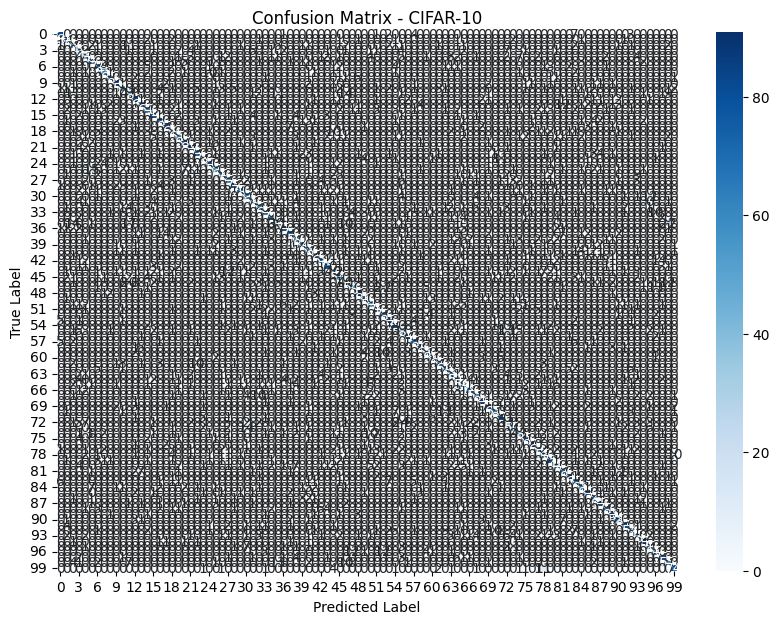

In [ ]:
# Initialize a new model for CIFAR-100 using the best CIFAR-10 (ReLU 3x3) weights
model_cifar100 = CNNModel(num_classes=100, activation='relu', kernel_size=3).to(device)
pretrained_dict = torch.load("/content/relu_3x3.pth")
# Exclude the final FC layer weights 
pretrained_dict = {k: v for k, v in pretrained_dict.items() if 'fc' not in k}
model_cifar100.load_state_dict(pretrained_dict, strict=False)
# Reinitialize the FC layer for 100 classes
model_cifar100.fc = nn.Linear(512, 100).to(device)

# Use SGD with momentum and weight decay as the optimizer
optimizer = optim.SGD(model_cifar100.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
# Use a StepLR scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Modified train_model function to handle different types of schedulers
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler,
                num_epochs=50, save_path="model.pth", early_stop_patience=5):
    best_val_loss = float('inf')
    best_val_acc = 0.0
    early_stop_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = 100 * correct / total

        # Validate model on validation set
        model.eval()
        val_running_loss = 0.0
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        val_loss = val_running_loss / len(val_loader.dataset)
        val_acc = 100 * val_correct / val_total

        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(val_loss)
        else:
            scheduler.step()

        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_acc = val_acc
            torch.save(model.state_dict(), save_path)
            print(f"--> Best model saved with Val Loss: {best_val_loss:.4f} and Val Acc: {best_val_acc:.2f}%")
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            print(f"Early stop counter: {early_stop_counter}/{early_stop_patience}")
            if early_stop_counter >= early_stop_patience:
                print("Early stopping triggered.")
                break

    print("Training complete.")

# Define the loss function (unchanged)
criterion = nn.CrossEntropyLoss()

# Train with the new optimizer and scheduler settings
train_model(model_cifar100, train_loader_cifar100, val_loader_cifar100, criterion, optimizer, scheduler,
            num_epochs=30, save_path="sgd_relu_cifar100.pth", early_stop_patience=5)

# Load the best saved model and evaluate on CIFAR-100
model_cifar100.load_state_dict(torch.load("sgd_relu_cifar100.pth"))
print("Evaluation on CIFAR-100 with SGD and StepLR:")
evaluate_model(model_cifar100, test_loader_cifar100)

For CIFAR‑100, we leveraged transfer learning by initializing our model with the best CIFAR‑10 (ReLU 3×3) weights—excluding the final FC layer, which was then reinitialized to output 100 classes. In our hypertuning process, we switched from Adam to SGD with momentum (lr = 0.1, momentum = 0.9, weight decay = 5e‑4) and adopted a StepLR scheduler that decays the learning rate by a factor of 0.1 every 10 epochs. We also implemented early stopping with a patience of 5 epochs to prevent overfitting. Over the course of 30 epochs, training loss steadily decreased and validation accuracy improved from roughly 30% to about 68–69%. Ultimately, the best model achieved an F1 score of approximately 0.689 (69%), which is slightly higher than the previous model.

### Frozen Schedule

Phase 1: Training with frozen backbone (only FC layer is trainable).
Frozen Epoch [1/10] | Train Loss: 3.7525, Train Acc: 13.08% | Val Loss: 3.3198, Val Acc: 21.46%
--> Best model updated (frozen phase): Val Loss = 3.3198
Frozen Epoch [2/10] | Train Loss: 3.3447, Train Acc: 19.00% | Val Loss: 3.1671, Val Acc: 23.28%
--> Best model updated (frozen phase): Val Loss = 3.1671
Frozen Epoch [3/10] | Train Loss: 3.2392, Train Acc: 20.90% | Val Loss: 3.0606, Val Acc: 25.60%
--> Best model updated (frozen phase): Val Loss = 3.0606
Frozen Epoch [4/10] | Train Loss: 3.1837, Train Acc: 22.11% | Val Loss: 3.0221, Val Acc: 26.30%
--> Best model updated (frozen phase): Val Loss = 3.0221
Frozen Epoch [5/10] | Train Loss: 3.1387, Train Acc: 22.60% | Val Loss: 2.9669, Val Acc: 27.64%
--> Best model updated (frozen phase): Val Loss = 2.9669
Frozen Epoch [6/10] | Train Loss: 3.1074, Train Acc: 23.32% | Val Loss: 2.9164, Val Acc: 28.76%
--> Best model updated (frozen phase): Val Loss = 2.9164
Frozen Epoch 

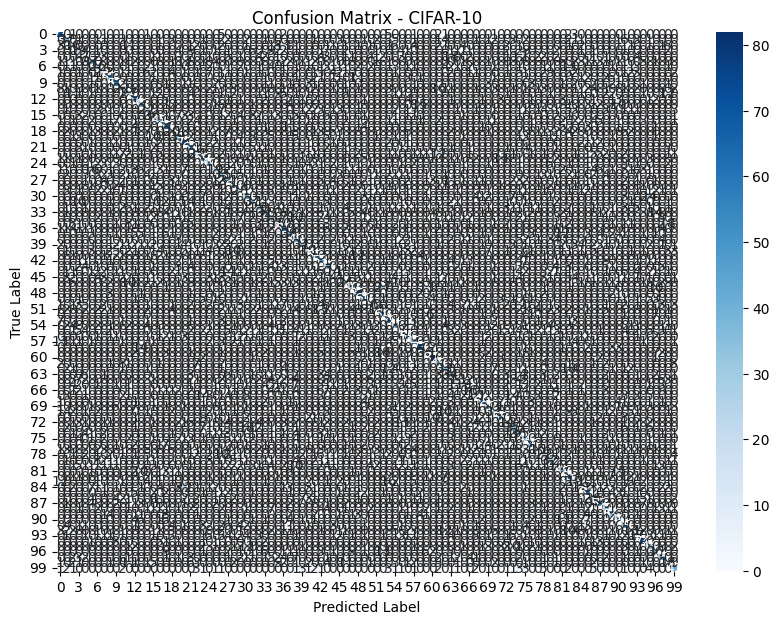

In [ ]:

# Define a new training function using a frozen schedule
def train_model_frozen_schedule(model, train_loader, val_loader, criterion,
                                freeze_epochs=5, total_epochs=30,
                                save_path="frozen_cifar100.pth", early_stop_patience=5):
    # Phase 1: Freeze backbone (all layers except final FC)

    print("Phase 1: Training with frozen backbone (only FC layer is trainable).")
    for name, param in model.named_parameters():
        if "fc" not in name:
            param.requires_grad = False

    # Create optimizer for only the trainable parameters
    optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()),
                          lr=0.01, momentum=0.9, weight_decay=5e-4)
    # For phase 1, we can use a simple StepLR scheduler
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=freeze_epochs, gamma=0.1)

    best_val_loss = float('inf')
    early_stop_counter = 0

    for epoch in range(freeze_epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = 100 * correct / total

        # Validate
        val_loss, val_acc = validate_model(model, val_loader, criterion)
        scheduler.step()

        print(f"Frozen Epoch [{epoch+1}/{freeze_epochs}] | "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), save_path)
            early_stop_counter = 0
            print(f"--> Best model updated (frozen phase): Val Loss = {best_val_loss:.4f}")
        else:
            early_stop_counter += 1
            print(f"Early stop counter (frozen phase): {early_stop_counter}/{early_stop_patience}")
            if early_stop_counter >= early_stop_patience:
                print("Early stopping triggered during frozen phase.")
                return


    # Phase 2: Unfreeze entire network for fine-tuning
   
    print("Phase 2: Unfreezing all layers for fine-tuning.")
    for param in model.parameters():
        param.requires_grad = True
    # Reinitialize the optimizer for all parameters
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    early_stop_counter = 0  # Reset early stopping counter
    for epoch in range(freeze_epochs, total_epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = 100 * correct / total

        val_loss, val_acc = validate_model(model, val_loader, criterion)
        scheduler.step()

        print(f"Fine-tuning Epoch [{epoch+1}/{total_epochs}] | "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), save_path)
            early_stop_counter = 0
            print(f"--> Best model updated (fine-tuning phase): Val Loss = {best_val_loss:.4f}")
        else:
            early_stop_counter += 1
            print(f"Early stop counter (fine-tuning phase): {early_stop_counter}/{early_stop_patience}")
            if early_stop_counter >= early_stop_patience:
                print("Early stopping triggered during fine-tuning phase.")
                break

    print("Training with frozen schedule complete.")


# Set up the model for CIFAR-100 fine-tuning using a frozen schedule

# Initialize a new model for CIFAR-100. Here we load the best CIFAR-10 (ReLU 3x3) weights.
model_cifar100 = CNNModel(num_classes=100, activation='relu', kernel_size=3).to(device)
pretrained_dict = torch.load("/content/relu_3x3.pth")
pretrained_dict = {k: v for k, v in pretrained_dict.items() if 'fc' not in k}
model_cifar100.load_state_dict(pretrained_dict, strict=False)
# Reinitialize the FC layer for 100 classes
model_cifar100.fc = nn.Linear(512, 100).to(device)

# Define loss function
criterion = nn.CrossEntropyLoss()

# Now use the frozen schedule training function.
train_model_frozen_schedule(model_cifar100, train_loader_cifar100, val_loader_cifar100,
                            criterion, freeze_epochs=10, total_epochs=40,
                            save_path="frozen_relu_cifar100.pth", early_stop_patience=5)

# Load the best saved model and evaluate on CIFAR-100
model_cifar100.load_state_dict(torch.load("frozen_relu_cifar100.pth"))
print("Evaluation on CIFAR-100 with Frozen Schedule:")
evaluate_model(model_cifar100, test_loader_cifar100)

In this experiment, we adopted a frozen schedule approach to fine-tune a CIFAR‑100 model initialized with the best CIFAR‑10 (ReLU 3×3) weights. The training was divided into two phases:

* Phase 1 – Frozen Backbone:

For the first 10 epochs, we froze all layers except the final fully connected layer. This meant that only the FC layer was updated during these epochs. We used SGD with a learning rate of 0.01 (with momentum and weight decay) along with a StepLR scheduler to gradually reduce the learning rate. The idea was to allow the newly initialized FC layer to start adapting to the CIFAR‑100 classes while keeping the pre-learned features intact.
* Phase 2 – Fine-Tuning:

After the frozen phase, we unfroze the entire network and reinitialized the optimizer (with a lower learning rate of 0.001) to fine-tune all layers. A new StepLR scheduler was set up to further reduce the learning rate every 10 epochs. We continued training until early stopping was triggered based on validation loss improvements.

* Result Analysis

The evaluation on CIFAR‑100 with this frozen schedule resulted in a test accuracy of roughly 39% and an F1 score of about 37.5%. These results are considerably lower than our earlier experiments that did not use a frozen schedule.

# 3. Performance Evaluation


Test Set Evaluation - CIFAR-10:
Accuracy: 0.8807
Precision: 0.8830
Recall: 0.8807
F1 Score: 0.8799


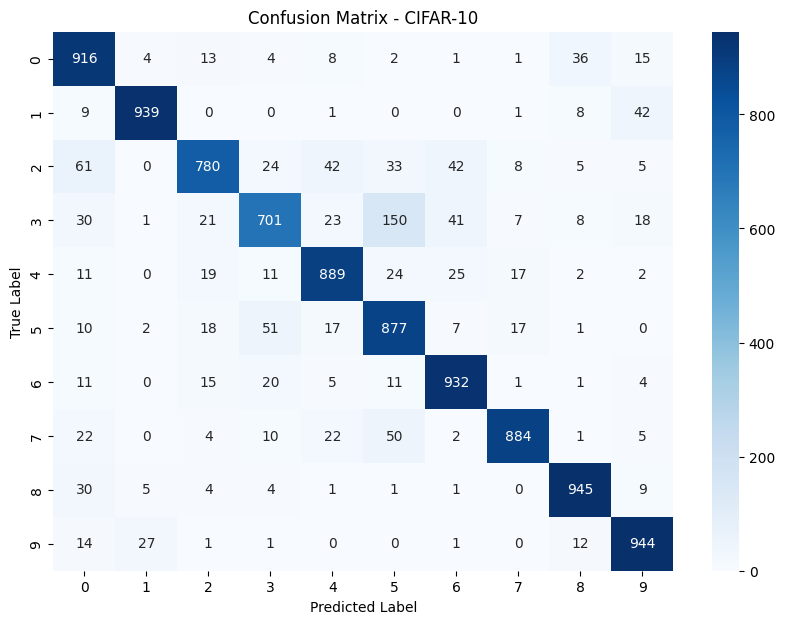

Evaluation on CIFAR-100 with SGD and StepLR:
Test Set Evaluation - CIFAR-10:
Accuracy: 0.6900
Precision: 0.6913
Recall: 0.6900
F1 Score: 0.6891


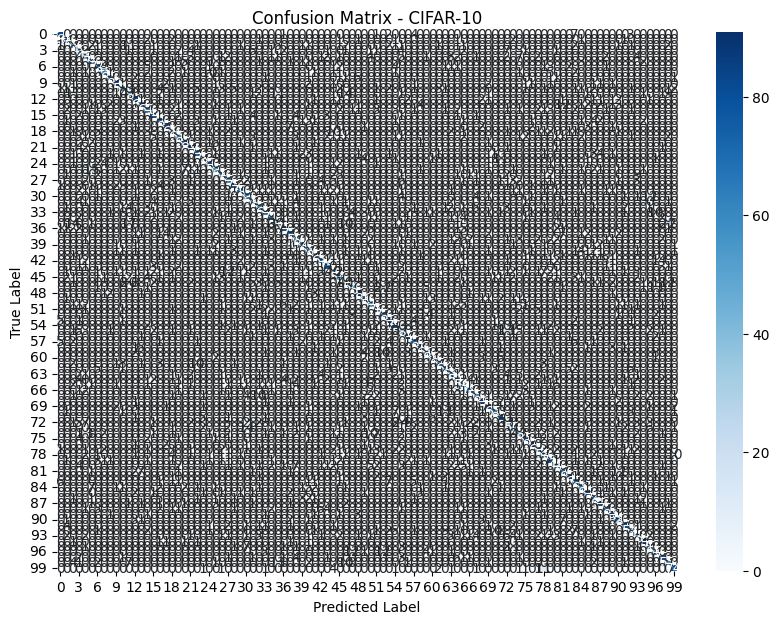

In [ ]:
evaluate_model(model_relu_3x3, test_loader)

model_cifar100.load_state_dict(torch.load("sgd_relu_cifar100.pth"))
print("Evaluation on CIFAR-100 with SGD and StepLR:")
evaluate_model(model_cifar100, test_loader_cifar100)

### Comparative analysis - Summary:

The CIFAR‑10 model (using ReLU with a 3×3 kernel) achieved high performance with an accuracy of approximately 88.1% and an F1 score near 0.88. In contrast, the CIFAR‑100 model, which fine‑tuned using SGD with StepLR—reached an accuracy of about 69.0% with an F1 score around 0.69.

This significant performance gap is expected because CIFAR‑10 involves only 10 classes with relatively distinct differences, making the classification task less complex. Meanwhile, CIFAR‑100 comprises 100 classes, which introduces higher inter-class similarity and more fine-grained distinctions. As a result, the model faces a much more challenging task when it comes to generalizing across a larger number of similar classes.

Moreover, the transfer learning approach from CIFAR‑10 to CIFAR‑100 can only provide a partial advantage—the learned features from CIFAR‑10 are not entirely sufficient to capture the intricate variations required for 100 classes. This analysis indicates that while the chosen architecture and optimization strategies work well for CIFAR‑10, further enhancements such as deeper networks, refined data augmentation, or additional architectural modifications might be necessary to bridge the performance gap on CIFAR‑100.

## Misclassified Image

CIFAR-10 Evaluation Metrics:
{'accuracy': 0.8807, 'precision': 0.8830333743721915, 'recall': 0.8806999999999998, 'f1': 0.8799268919604877}


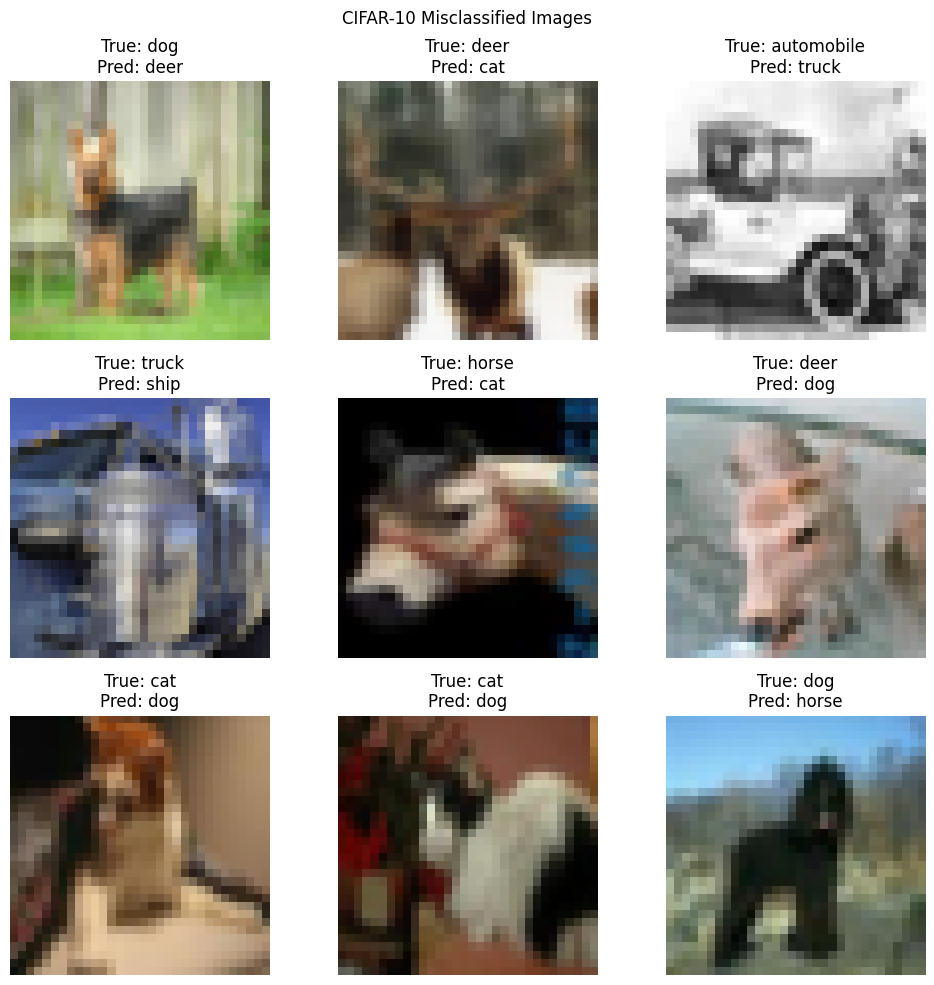

CIFAR-100 Evaluation Metrics:
{'accuracy': 0.69, 'precision': 0.6912845649128498, 'recall': 0.6899999999999998, 'f1': 0.6891230919628406}


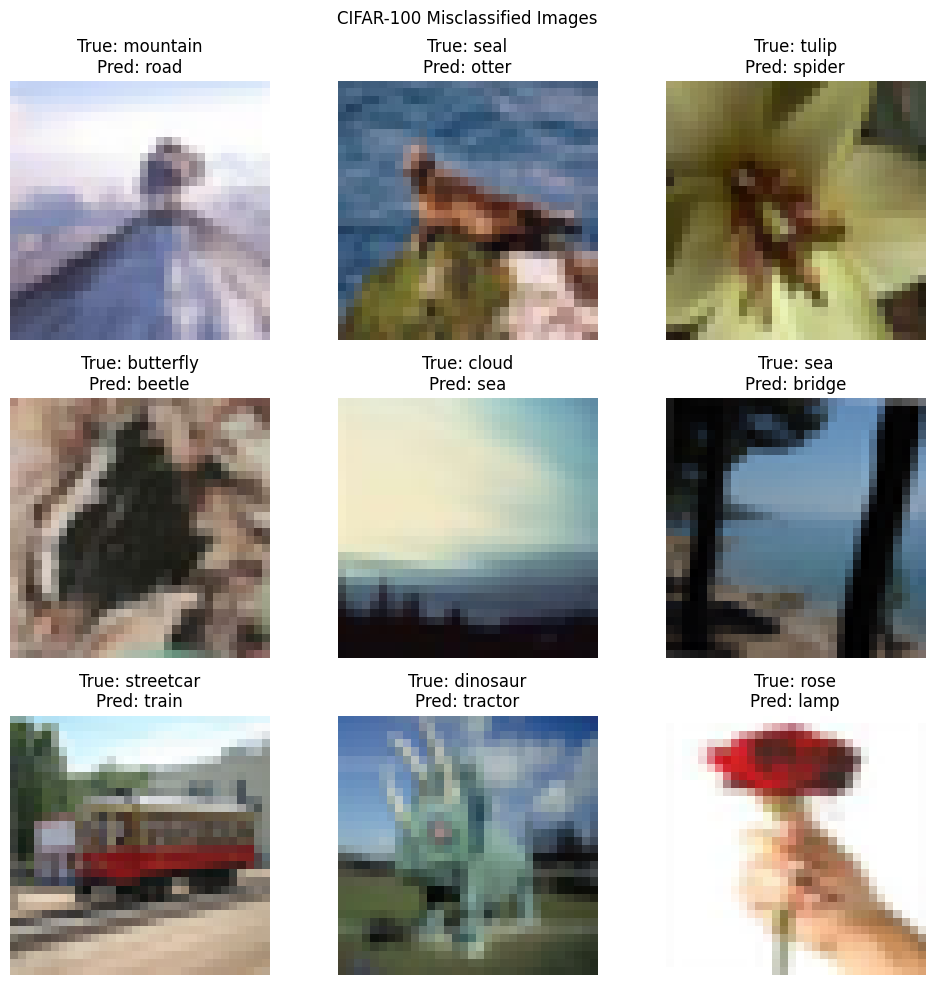

In [ ]:

def get_evaluation_metrics(model, test_loader):

    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    metrics = {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, average='macro'),
        "recall": recall_score(y_true, y_pred, average='macro'),
        "f1": f1_score(y_true, y_pred, average='macro')
    }
    return metrics, y_true, y_pred

def analyze_misclassified(model, test_loader, classes, num_images=9):

    model.eval()
    misclassified = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            for i in range(len(labels)):
                if preds[i] != labels[i]:
                    misclassified.append((images[i].cpu(), labels[i].cpu().item(), preds[i].cpu().item()))
                    if len(misclassified) >= num_images:
                        break
            if len(misclassified) >= num_images:
                break
    return misclassified


def plot_misclassified(misclassified, classes, title="Misclassified Images"):

    num_images = len(misclassified)
    plt.figure(figsize=(10, 10))
    for i, (img, true_label, pred_label) in enumerate(misclassified):
        plt.subplot(3, 3, i+1)
        # Unnormalize image: assuming transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
        img = img.numpy().transpose(1, 2, 0)
        img = (img * 0.5) + 0.5  # reverse normalization
        plt.imshow(img.clip(0,1))
        plt.title(f"True: {classes[true_label]}\nPred: {classes[pred_label]}")
        plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


# For CIFAR-10
cifar10_classes = train_loader.dataset.dataset.classes if hasattr(train_loader.dataset, 'dataset') else torchvision.datasets.CIFAR10.classes
metrics_c10, y_true_c10, y_pred_c10 = get_evaluation_metrics(model_relu_3x3, test_loader)
print("CIFAR-10 Evaluation Metrics:")
print(metrics_c10)

misclassified_c10 = analyze_misclassified(model_relu_3x3, test_loader, cifar10_classes, num_images=9)
plot_misclassified(misclassified_c10, cifar10_classes, title="CIFAR-10 Misclassified Images")

# For CIFAR-100
# Safely extract CIFAR-100 classes from the underlying dataset.
if hasattr(train_loader_cifar100.dataset, 'classes'):
    cifar100_classes = train_loader_cifar100.dataset.classes
elif hasattr(train_loader_cifar100.dataset, 'dataset'):
    cifar100_classes = train_loader_cifar100.dataset.dataset.classes
else:
    # Fallback: load the dataset and use its classes attribute.
    cifar100_temp = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
    cifar100_classes = cifar100_temp.classes

# Now proceed with evaluation
metrics_c100, y_true_c100, y_pred_c100 = get_evaluation_metrics(model_cifar100, test_loader_cifar100)
print("CIFAR-100 Evaluation Metrics:")
print(metrics_c100)

misclassified_c100 = analyze_misclassified(model_cifar100, test_loader_cifar100, cifar100_classes, num_images=9)
plot_misclassified(misclassified_c100, cifar100_classes, title="CIFAR-100 Misclassified Images")

Insights:

* CIFAR 10:
We can see some misclassied from CIFAR 10 that the model predicted dog as deer, Deer as cat and Automobile as Truck.
  * Dog as deer: The dog might be small in the frame or partially occluded, causing the network to focus on background or shape cues that resemble a deer.
  * Deer as Cat: The image might have an unusual pose, background, or color patterns that the network associates more closely with cats (e.g., fur texture, ears).
  * Automobile as Truck:  Both classes share common structural features (four wheels, a chassis). If the car is at a certain angle, or if part of it is occluded, the model might see a “boxy” shape more akin to a truck.

Recommendation: We could have more robust data augmentation to process the image, as well as focusing on bounding regions of interest, could help the network learn more discriminative dog features. Additionally, gathering more diverse training samples of deer and cars so the model can pick up more nuanced details.

* CIFAR 100:
Some misclassified image from CIFAR 100 are: Mountain predicted as Road, Seal Predicted as otter and Tulip predicted as splider
  * Mountain as Road: The horizon line or rocky surface might visually resemble a road surface from the model’s perspective.
  * Seal as otter: Both are marine mammals with somewhat similar shapes and coloring. Differences may not be prominent in low-resolution CIFAR images.
  * Tulip as Spider: A close-up of the flower petals or stamens might visually form shapes the model interprets as legs or a spider’s body.

Recommendation:  We can employ color-jitter augmentations and multi-scale training so the model can better learn petal textures and floral structures, thus reducing confusion with spider-like shapes. Additionally, using additional context-aware augmentations or a larger-capacity network that can learn to distinguish background textures from actual features (e.g., lane markings, asphalt patterns, floral structure).



## Visualization

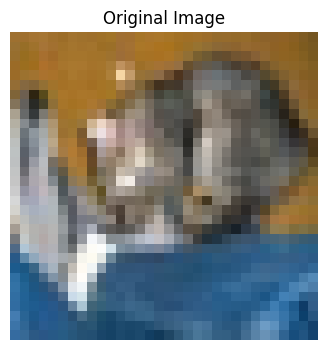

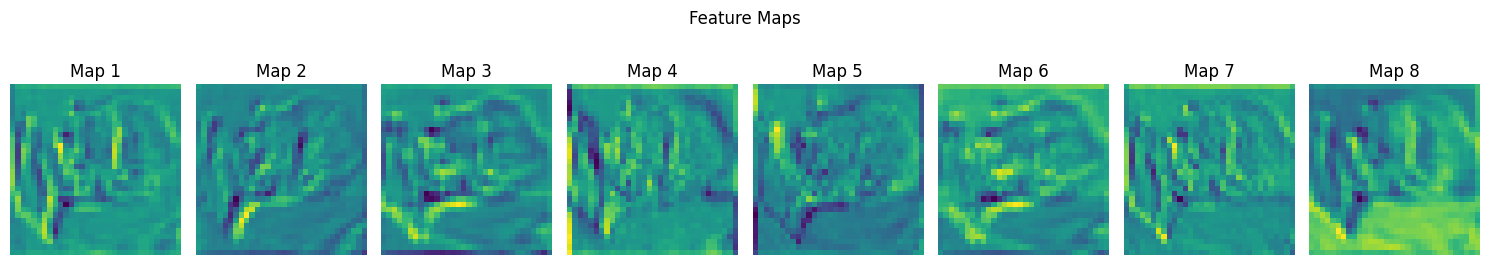

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


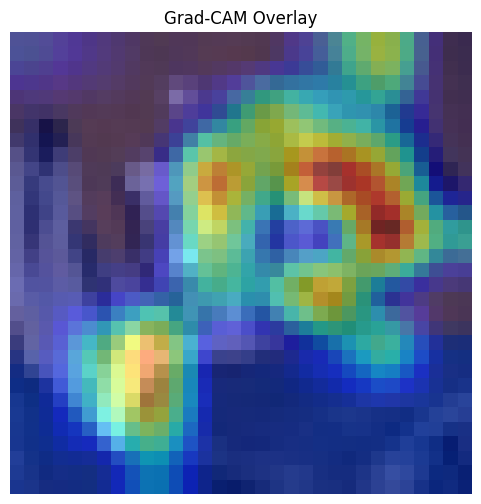

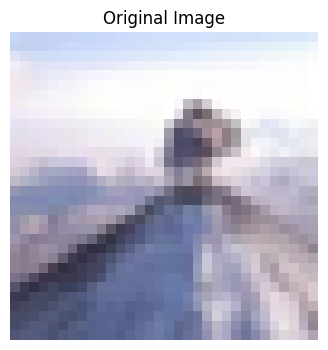

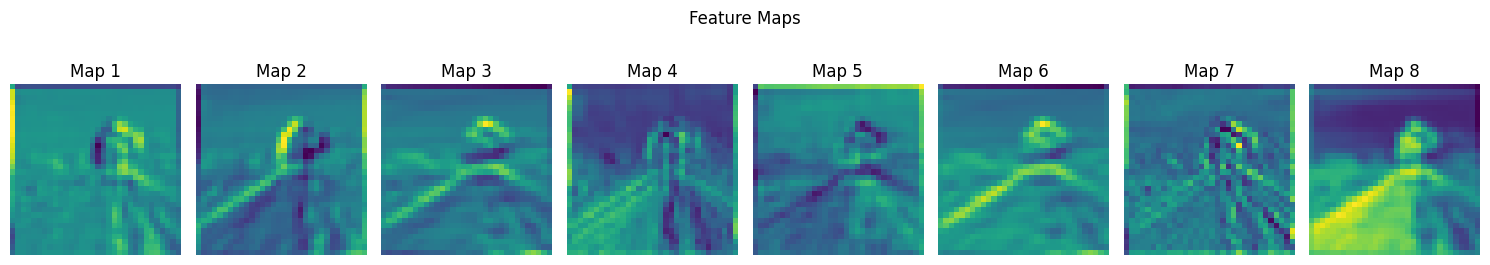

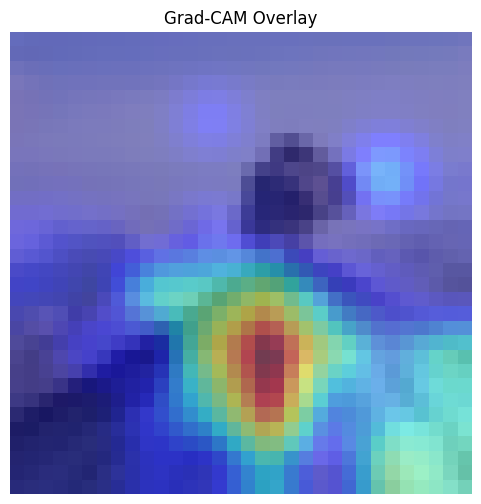

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np



# 1. Feature Maps Visualization Function

def visualize_feature_maps(model, target_layer, test_loader, num_maps=8):

    model.eval()
    activations = []

    # Define a forward hook to capture the output of the target layer
    def hook_fn(module, input, output):
        activations.append(output.detach())

    hook_handle = target_layer.register_forward_hook(hook_fn)

    # Get one batch of test images
    images, _ = next(iter(test_loader))
    images = images.to(device)
    # Forward pass
    with torch.no_grad():
        _ = model(images)
    # Remove the hook to avoid memory leak
    hook_handle.remove()

    # Select the first image from the batch and its corresponding feature maps
    feature_maps = activations[0][0]  
    num_feature_maps = feature_maps.shape[0]
    num_to_show = min(num_maps, num_feature_maps)

    # Unnormalize the original image 
    orig_img = images[0].cpu().numpy().transpose(1, 2, 0)
    orig_img = (orig_img * 0.5) + 0.5  

    # Plot original image
    plt.figure(figsize=(4,4))
    plt.imshow(np.clip(orig_img, 0, 1))
    plt.title("Original Image")
    plt.axis("off")
    plt.show()

    # Plot selected feature maps
    fig, axes = plt.subplots(1, num_to_show, figsize=(15, 3))
    for i in range(num_to_show):
        axes[i].imshow(feature_maps[i].cpu().numpy(), cmap='viridis')
        axes[i].set_title(f"Map {i+1}")
        axes[i].axis("off")
    plt.suptitle("Feature Maps")
    plt.tight_layout()
    plt.show()


# 2. Grad-CAM Visualization Implementation

class GradCAM:
    def __init__(self, model, target_layer):

        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handles = []
        self._register_hooks()

    def _register_hooks(self):
        # Forward hook to capture activations
        def forward_hook(module, input, output):
            self.activations = output.detach()
        # Backward hook to capture gradients
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()
        self.hook_handles.append(self.target_layer.register_forward_hook(forward_hook))
        self.hook_handles.append(self.target_layer.register_backward_hook(backward_hook))

    def generate(self, input_tensor, class_idx=None):

        self.model.zero_grad()
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = output.argmax(dim=1)
        one_hot = torch.zeros_like(output)
        for i in range(output.size(0)):
            one_hot[i, class_idx[i]] = 1
        output.backward(gradient=one_hot, retain_graph=True)

        # Global average pooling of gradients
        weights = self.gradients.mean(dim=(2,3), keepdim=True)
        grad_cam_map = torch.relu((weights * self.activations).sum(dim=1, keepdim=True))
        # Upsample heatmap to input size
        grad_cam_map = F.interpolate(grad_cam_map, size=input_tensor.shape[2:], mode='bilinear', align_corners=False)
        # Normalize the heatmap
        grad_cam_map = (grad_cam_map - grad_cam_map.min()) / (grad_cam_map.max() - grad_cam_map.min() + 1e-8)
        return grad_cam_map

    def remove_hooks(self):
        for handle in self.hook_handles:
            handle.remove()

def visualize_grad_cam(model, target_layer, test_loader):

    model.eval()
    images, _ = next(iter(test_loader))
    images = images.to(device)

    grad_cam = GradCAM(model, target_layer)
    heatmaps = grad_cam.generate(images)
    grad_cam.remove_hooks()

    # Unnormalize the first image 
    orig_img = images[0].cpu().numpy().transpose(1,2,0)
    orig_img = (orig_img * 0.5) + 0.5
    heatmap = heatmaps[0, 0].cpu().numpy()

    plt.figure(figsize=(6,6))
    plt.imshow(np.clip(orig_img, 0, 1))
    plt.imshow(heatmap, cmap='jet', alpha=0.5)
    plt.title("Grad-CAM Overlay")
    plt.axis("off")
    plt.show()


# Visualize feature maps from the first convolutional layer.
visualize_feature_maps(model_relu_3x3, model_relu_3x3.conv1, test_loader)

visualize_grad_cam(model_relu_3x3, model_relu_3x3.resblock3, test_loader)

visualize_feature_maps(model_cifar100, model_cifar100.conv1, test_loader_cifar100)

visualize_grad_cam(model_cifar100, model_cifar100.resblock3, test_loader_cifar100)

### Insights from feature map

The feature maps from the first convolutional layer highlight low-level image features such as edges, corners, simple textures, and color transitions. These are often the building blocks that deeper layers later combine into more complex patterns.

For example: in the first image, the first layer from CIFAR 10 model might show faint outlines of the animal’s face or body edges. You can see that the filters capture basic visual elements such as edges, corners, and simple textures. Some maps clearly highlight horizontal or vertical edges, while others capture color transitions. This confirms that the network is learning to decompose the image into its fundamental components.

In the second image from CIFAR 100, the overall patterns are similar in that early layers extract similar low-level features. Some maps highlight vertical, horizontal, or diagonal edges. However, we do see that there is not a obvious difference between the first feature map and the last one, indicating that Certain filters respond to repeated patterns or simple shapes (like corners or curves), which form the basic building blocks for more complex representations in deeper layers.


### Insights from Grad-CAM Visualization

* CIFAR 10 Model:

The Grad‑CAM overlays for the CIFAR‑10 model, using the deeper layer in resblock3, show bright, concentrated regions over the main object in the image. This indicates that the network is focusing on the most discriminative parts of the object— the cat in the image, which gives us confidence that the model’s decision is based on meaningful visual cues.

* CIFAR 100 Mode:

For the CIFAR‑100 model, the Grad‑CAM visualizations appear too concentrating in the middle of image, not highlighting the overall object - the mountain in the image, which less precisely aligned with the object of interest. This suggests that, while the model is trying to focus on all relevant regions, the task’s higher complexity lead to more uncertainty. In this case, the highlighted regions did not include all of the object, reflecting the difficulty in distinguishing subtle differences between similar classes.

# Future Improvement

Based on our observations, several avenues can be explored to further enhance performance, especially on CIFAR‑100:

* Deeper and More Complex Architectures: Investigate the use of deeper networks or models incorporating attention mechanisms to capture fine-grained features more effectively.

* Enhanced Data Augmentation: Implement additional augmentation techniques such as mixup, cutmix, or more aggressive cropping and rotation to increase data variability.

* Dynamic Unfreezing Strategies: Experiment with more dynamic or gradual unfreezing schedules to better balance the retention of pre-trained features with the need for fine-tuning.

* Pretraining on Larger Datasets: Consider pretraining on a larger, more diverse dataset (such as ImageNet) to obtain richer feature representations before fine-tuning on CIFAR‑100.

* Ensemble Methods: Combining predictions from multiple models or using ensembles could help mitigate errors and improve overall performance.
